In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

import pandas as pd
import numpy as np
import urllib
import json
import datetime

from utils import get_daily_demand_data, plot_series
import os

TensorFlow version:  2.3.4


In [ ]:
!pip install --user google-cloud-bigquery==1.25.0

In [2]:
# Change with your own bucket and project below:
BUCKET =  "qwiklabs-gcp-01-0ff01705a7ea"
PROJECT = BUCKET

OUTDIR = "gs://{bucket}/demand/data/".format(bucket=BUCKET)

os.environ['BUCKET'] = BUCKET
os.environ['OUTDIR'] = OUTDIR
os.environ['PROJECT'] = PROJECT

In [11]:
start_date = '2019-04-01'
end_date = '2020-03-31' 

NORM_VALUE = 1e6 # divided all values normalization

values, times = get_daily_demand_data(start_date, end_date, write_json=False)
values = values / NORM_VALUE

dataset = pd.DataFrame({'times': times, 'values': values})
dataset.to_csv("data/dataset.csv", index=False)

In [13]:
start_date = '2020-04-01'
end_date = '2020-04-30' 

NORM_VALUE = 1e6 # divided all values normalization

values_eval, times_eval = get_daily_demand_data(start_date, end_date, write_json=False)
values_eval = values_eval / NORM_VALUE

dataset = pd.DataFrame({'times': times_eval, 'values': values_eval})
dataset.to_csv("data/dataset_eval.csv", index=False)

(366,) (30,)


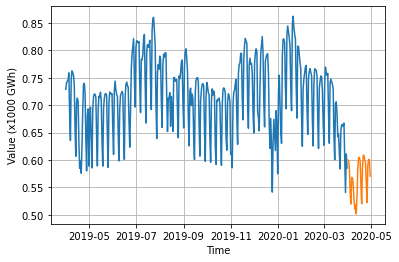

In [15]:
plot_series(times, values)
plot_series(times_eval, values_eval)

print(values.shape, values_eval.shape)

## Create BQ Dataset

In [ ]:
# https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/feature_engineering/labs/1_bqml_basic_feat_eng_bqml-lab.ipynb

In [ ]:
%%bash
# Create a BigQuery dataset

# !gsutil cp -r data OUTDIR

datasetexists=$(bq ls -d | grep -w demand_pred)

if [ -n "$datasetexists" ]; then
    echo -e "BigQuery dataset already exists, let's not recreate it."

else
    echo "Creating BigQuery dataset"
    
    bq --location=US mk --dataset \
        --description 'Demand prediction' \
        $PROJECT:demand_pred
   echo "Here are your current datasets:"
   bq ls
fi

In [ ]:
%%bash

bq load --autodetect \
        --location=US \
        --source_format=CSV \
        $PROJECT:demand_pred.dataset \
        data/dataset.csv 

In [ ]:
%%bash

bq load --autodetect \
        --location=US \
        --source_format=CSV \
        $PROJECT:demand_pred.dataset_eval \
        data/dataset_eval.csv 

In [ ]:
%%bigquery
 
SELECT times, values, EXTRACT(DAYOFWEEK FROM times) as dow
FROM
  demand_pred.dataset

## Create Arima Model!

In [16]:
%%bigquery

CREATE OR REPLACE MODEL
    demand_pred.baseline_model OPTIONS(MODEL_TYPE='ARIMA_PLUS',
         time_series_timestamp_col='times',
         time_series_data_col='values') AS
SELECT
  times,
  values
FROM
  demand_pred.dataset

""


In [17]:
%%bigquery

SELECT *
FROM
  ML.ARIMA_EVALUATE(MODEL `demand_pred.baseline_model`, STRUCT(FALSE AS show_all_candidate_models))

,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,2,0,1,False,958.419448,-1906.838896,0.000153,[WEEKLY],False,False,False,


In [18]:
%%bigquery

# forecast with arima model

SELECT *
FROM
  (SELECT * 
   FROM ML.FORECAST(MODEL `demand_pred.baseline_model`,
              STRUCT(30 AS horizon, 0.8 AS confidence_level))),
    (SELECT times, values 
     FROM demand_pred.dataset_eval)
    

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound,times,values
0,2020-04-09 00:00:00+00:00,0.732062,0.025788,0.8,0.698995,0.765129,0.698995,0.765129,2020-04-06,0.568144
1,2020-04-09 00:00:00+00:00,0.732062,0.025788,0.8,0.698995,0.765129,0.698995,0.765129,2020-04-14,0.584017
2,2020-04-09 00:00:00+00:00,0.732062,0.025788,0.8,0.698995,0.765129,0.698995,0.765129,2020-04-24,0.594662
3,2020-04-09 00:00:00+00:00,0.732062,0.025788,0.8,0.698995,0.765129,0.698995,0.765129,2020-04-27,0.590580
4,2020-04-09 00:00:00+00:00,0.732062,0.025788,0.8,0.698995,0.765129,0.698995,0.765129,2020-04-15,0.604347
...,...,...,...,...,...,...,...,...,...,...
895,2020-04-17 00:00:00+00:00,0.736404,0.027449,0.8,0.701207,0.771601,0.701207,0.771601,2020-04-11,0.518230
896,2020-04-17 00:00:00+00:00,0.736404,0.027449,0.8,0.701207,0.771601,0.701207,0.771601,2020-04-12,0.501615
897,2020-04-17 00:00:00+00:00,0.736404,0.027449,0.8,0.701207,0.771601,0.701207,0.771601,2020-04-30,0.570635
898,2020-04-17 00:00:00+00:00,0.736404,0.027449,0.8,0.701207,0.771601,0.701207,0.771601,2020-04-03,0.584684


## Create Model!

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL
    demand_pred.baseline_model OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  pickup_datetime,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
FROM
  feat_eng.feateng_training_data